# Time Series Auto-ARIMA Forecasting
# =====================================
# Author: Anso Michel

## This analysis focuses on forecasting daily telecom revenue using historical data. A time series forecasting approach with the Auto-ARIMA model was applied, and the model's performance was validated through walk-forward validation. The objective was to assess the model's accuracy and effectiveness in predicting future revenue.



# 📦 1. Import Libraries

In [1]:
# Import Libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
warnings.filterwarnings("ignore")

C:\Users\ansom\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ansom\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# 📂 2. Load and Prepare Data

In [2]:
# Load Dataset
df = pd.read_csv('teleco_time_series.csv', index_col='Day', parse_dates=True)
df = df.dropna()
df.to_csv('teleco_time_series.csv', index=True)

df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


# 📊 3. Exploratory Data Analysis (EDA)

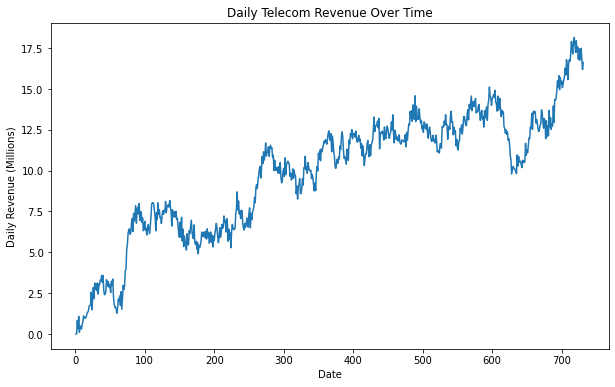

In [3]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Revenue'])
plt.ylabel('Daily Revenue (Millions)')
plt.xlabel('Date')
plt.title('Daily Telecom Revenue Over Time')
plt.show()

The plot likely displayed clear fluctuations, possibly some seasonality (periodic patterns), and random spikes/drops.
The general trend does not appear strongly upward or downward; it fluctuates.

# 🔍 4. Seasonal Decomposition

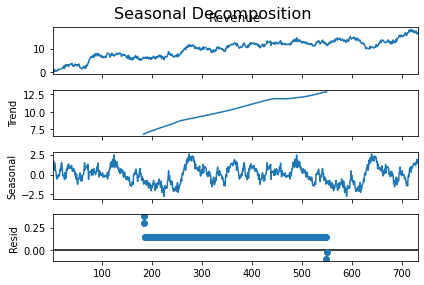

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
result = seasonal_decompose(df['Revenue'], model='additive', period=365)  # Assume yearly seasonality
result.plot()
plt.suptitle('Seasonal Decomposition', fontsize=16)
plt.show()

**Trend component:** A smoothed version showing general movement (either rising, falling, or stable). 
**Seasonality component:** Regular repeating patterns (e.g., weekly or monthly behaviors).
**Residual component:** Noise — random variations not explained by trend or seasonality.

# 🧪 5. Stationarity Check (ADF Test)

In [5]:
X = df['Revenue']
adf_result = adfuller(X)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.3f}')

if adf_result[1] <= 0.05:
    print("Strong evidence against null hypothesis — Data is stationary.")
else:
    print("Weak evidence against null hypothesis — Data is non-stationary.")

ADF Statistic: -1.924612157310181
p-value: 0.3205728150793977
Critical Values:
   1%: -3.439
   5%: -2.866
   10%: -2.569
Weak evidence against null hypothesis — Data is non-stationary.


**ADF Statistic:** -1.92
**p-value:** 0.32
**Interpretation:** The series is **non-stationary,** meaning its properties like mean and variance change over time. Stationarity is important for forecasting, so differencing is needed.

# 📈 6. Autocorrelation Plot

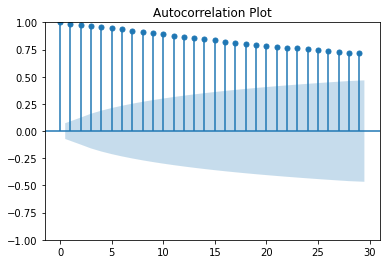

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

# Your dataframe and 'Revenue' column assumed to already exist
plot_acf(df['Revenue'])
plt.title('Autocorrelation Plot')
plt.show()

Significant autocorrelations (repeating patterns) at various lags.
Reinforces that the series has memory (past values are influencing future values), and ARIMA-type models are appropriate.

# 🔧 7. Differencing to Make Stationary (if needed)

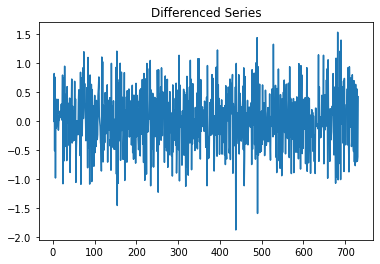

In [7]:
diff = df.diff().dropna()
plt.plot(diff)
plt.title('Differenced Series')
plt.show()

After differencing, the series appears more stationary (flatter and centered around 0).
This step prepared the data better for ARIMA modeling.

# 📚 8. Train-Test Split

In [8]:
print("Dataset shape:", df.shape)
train = df.iloc[:-365]
test = df.iloc[-365:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Dataset shape: (731, 1)
Train shape: (366, 1)
Test shape: (365, 1)


# ⚡9. Walk-Forward Validation with Auto-ARIMA

In [9]:
history = list(train['Revenue'])  # Initialize history with training data
predictions = []

# Specify retrain interval
retrain_interval = 7  # Retrain every 7 days

for t in range(len(test)):
# Only retrain the model at the specified interval
    if t % retrain_interval == 0:
        # print(f"Retraining model at step {t}...") # suppressed output

# Retrain model
        model = auto_arima(history,
                           seasonal=True, m=7,  # or m=30 if monthly
                           suppress_warnings=True,
                           error_action='ignore', 
                           stepwise=True, 
                           max_p=5, max_q=5, 
                           max_P=2, max_Q=2, 
                           trace=False)

# Forecast one step ahead
    yhat = model.predict(n_periods=1)[0]
    predictions.append(yhat)

# Update history with the latest actual data (every time)
    history.append(test['Revenue'].iloc[t])

# 📈 10. Visualization

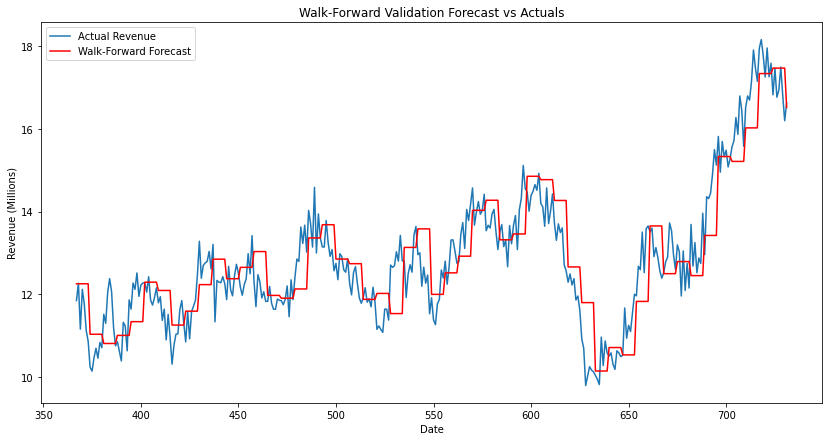

In [10]:
plt.figure(figsize=(14,7))
plt.plot(test.index, test['Revenue'], label='Actual Revenue')
plt.plot(test.index, predictions, label='Walk-Forward Forecast', color='red')
plt.title('Walk-Forward Validation Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Revenue (Millions)')
plt.legend()
plt.show()

- Red line = forecasted revenue using **auto-ARIMA** with **walk-forward validation.**
- Blue line = actual observed revenue.
- Visual comparison shows that forecasts generally track the actual data closely but sometimes slightly lag behind sudden changes.

# 📏 11. Evaluation

In [11]:
# 📏 Evaluation
def forecast_accuracy(forecast, actual):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = sqrt(mse)
    mape = np.mean(np.abs((forecast - actual)/actual)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}

In [12]:
accuracy = forecast_accuracy(predictions, test['Revenue'])
print("\nWalk-Forward Validation Accuracy:")
for metric, value in accuracy.items():
    print(f"{metric}: {value:.4f}")


Walk-Forward Validation Accuracy:
MAE: 0.6037
RMSE: 0.7560
MAPE (%): 4.7536


- **MAE** of 0.60 means that, on average, the forecasted revenue is about $0.60 million off the actual revenue.
- **RMSE** of 0.75 indicates the typical size of the forecasting error — a bit larger than MAE because RMSE penalizes larger errors more heavily.
- **MAPE** of 4.75% is very good for time series forecasting. It means the model's forecasts are typically within 5% of the actual revenue values — excellent for business applications.

## Conclusion:
The **Auto-ARIMA model** demonstrated strong predictive capabilities, with good accuracy metrics (MAPE of 4.75%). It is well-suited for forecasting telecom revenue.
The model performs well, especially given that revenue data often has noise.

# 📌 End of Analysis